# Predicting TFEX Market Movements with Recurrent Neural Networks (RNN)

This notebook addresses two key predictive tasks using short-term historical market data from TFEX (Thailand Futures Exchange):

- **Regression**: Predict the next-step log return (R).
- **Classification**: Predict the direction of the next return (Y = 1 if R > 0, else 0).

You will build and evaluate RNN-based models for both tasks, and assess their practical value in a trading context.


# Task 1
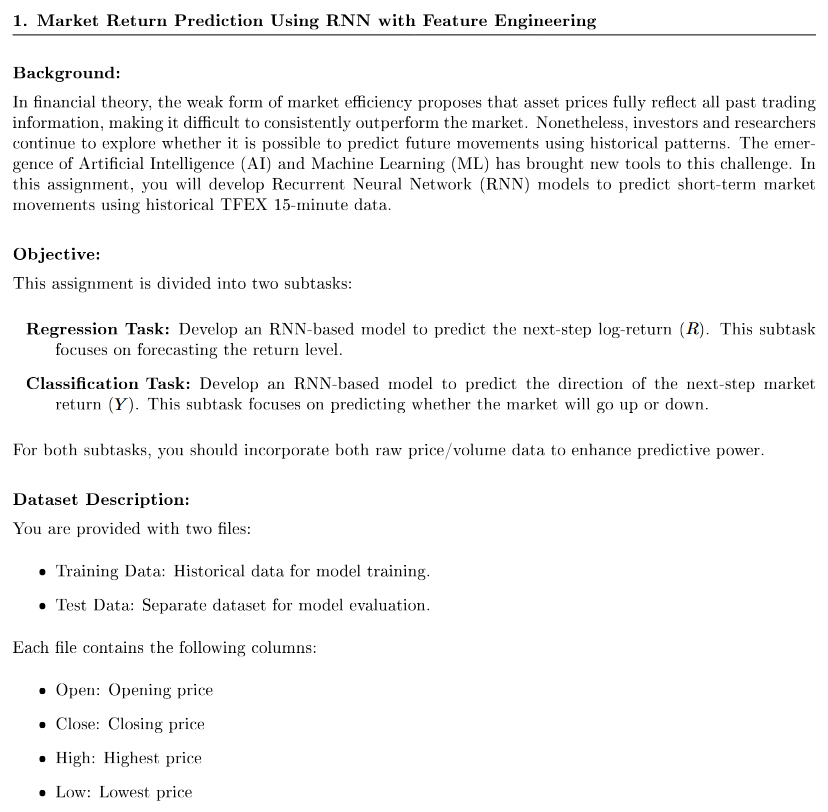
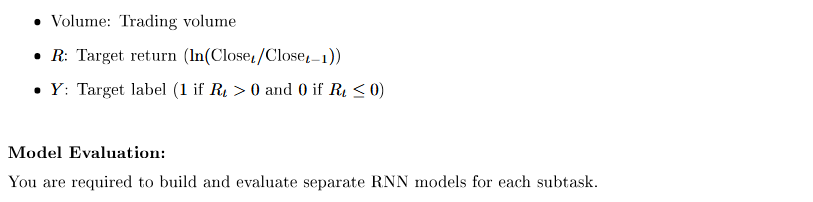

## 📦 1. Import Required Libraries

We import libraries for:
- Data manipulation (`pandas`, `numpy`)
- Preprocessing and evaluation (`scikit-learn`)
- Deep learning modeling (`TensorFlow` and `Keras`)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

## 📁 2. Load and Inspect the Dataset

We are provided with two CSV files:
- `TFEX_train.csv`: Contains historical 15-minute trading data for model training
- `TFEX_test.csv`: Contains unseen data for testing model performance

Each file includes the following columns:
- **Open, High, Low, Close**: OHLC price data
- **Volume**: Number of trades/contracts
- **R**: Log return = ln(Close_t / Close_{t−1})
- **Y**: Binary label (1 if R > 0, else 0)


In [4]:
# --- Load Data ---
train_path = "C:/Deep learning/Data HW4/Train.csv"
test_path = "C:/Deep learning/Data HW4/Test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

,Symbol,Date,Open,High,Low,Close,Volume,R,Y
0,SET50,1/4/2022 10:00,996.66,998.84,996.35,997.98,129716864,0.001815,1
1,SET50,1/4/2022 10:05,997.75,999.25,997.75,998.10,83876864,0.000120,1
2,SET50,1/4/2022 10:10,998.44,998.44,996.46,996.46,260697504,-0.001644,0
3,SET50,1/4/2022 10:15,996.60,997.33,995.37,997.33,68446400,0.000873,1
4,SET50,1/4/2022 10:20,996.22,996.83,995.63,996.10,95742336,-0.001234,0


## 🔧 3. Data Preprocessing and Scaling

To prepare for RNN modeling:
- Select relevant features: `Open`, `High`, `Low`, `Close`, `Volume`, `R`
- Normalize the values using MinMaxScaler for improved model convergence
- Target columns `R` and `Y` are kept separately for each task


In [5]:
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'R']

# --- Feature Normalization ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_df[feature_cols])
X_test_scaled = scaler.transform(test_df[feature_cols])


## 🔁 4. Sequence Preparation

RNN models expect sequences as input, not independent observations.

We define a function that:
- Takes the scaled features and target
- Creates overlapping input windows of fixed size (e.g., 10 timesteps)
- Each sequence (X) maps to the next-step target value (y)

This structure allows the RNN to learn temporal dependencies from past market patterns.


In [6]:
# --- Sequence Generation Function ---
def create_sequences(data, target, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 10
y_raw_train = train_df['R'].values
y_raw_test = test_df['R'].values


## 📉 5. Subtask 1: Regression – Predicting Next-Step Log Return (R)
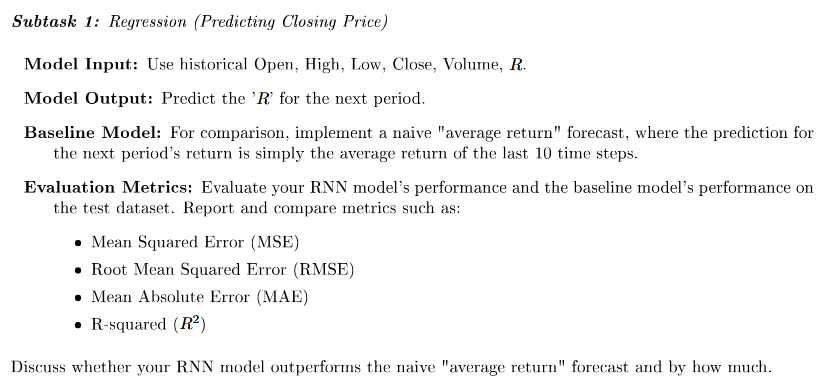

---
In this task:
- We build an RNN model to forecast the *value* of the next-step return `R`
- This is a **regression problem**
- The goal is to compare our model’s predictions with a simple baseline:
  - **Naive Baseline**: Predict the next return as the average of the last 10 observed returns
### 🔹 5.1 Prepare Input Sequences for Regression

Transform the scaled training and test sets into supervised learning format:
- Inputs `X`: sequences of the past 10 timesteps (feature matrix)
- Target `y`: the return value (`R`) at the next timestep


In [7]:
# --- Sequence Creation ---
X_train_reg, y_train_reg = create_sequences(X_train_scaled, y_raw_train, time_steps)
X_test_reg, y_test_reg = create_sequences(X_test_scaled, y_raw_test, time_steps)

# --- Target Normalization ---
y_scaler = MinMaxScaler()
y_train_reg_scaled = y_scaler.fit_transform(y_train_reg.reshape(-1, 1)).flatten()
y_test_reg_scaled = y_scaler.transform(y_test_reg.reshape(-1, 1)).flatten()


### 🔹 5.2 Build and Train the RNN Model for Regression

We use an LSTM (Long Short-Term Memory) layer to capture temporal dynamics in financial data.

Model architecture:
- LSTM layer with 50 units
- Dense output layer with 1 unit (for predicting a continuous return)
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam


In [9]:
# --- RNN Model ---
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    Dropout(0.1),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss=Huber())

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_reg, y_train_reg_scaled,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0048 - val_loss: 6.3470e-04
Epoch 2/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.0524e-04 - val_loss: 6.1764e-04
Epoch 3/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.0208e-04 - val_loss: 6.4182e-04
Epoch 4/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.8424e-04 - val_loss: 6.1495e-04
Epoch 5/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.0684e-04 - val_loss: 6.1456e-04
Epoch 6/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.7366e-04 - val_loss: 6.6138e-04
Epoch 7/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.5641e-04 - val_loss: 6.1518e-04
Epoch 8/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.9025e-04 - val_loss: 6.3175e-04
Epoch 9/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.7863e-04 - val_loss: 6.1098e-04
Epoch 10/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.8041e-04 - val_loss: 6.1060e-04
Epoch 11/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

### 🔹 5.3 Evaluate the RNN Regression Model

We evaluate both:
- Our RNN model
- The naive average-return baseline

Metrics reported:
- **MSE**: Mean Squared Error
- **RMSE**: Root Mean Squared Error
- **MAE**: Mean Absolute Error
- **R²**: Coefficient of determination

This comparison helps assess if the RNN model provides better forecasting accuracy.


In [11]:
# --- Predict and Inverse Transform ---
y_pred_scaled = model.predict(X_test_reg).flatten()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# --- Evaluation ---
mse = mean_squared_error(y_test_reg, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred)
r2 = r2_score(y_test_reg, y_pred)

# --- Naive Baseline (Mean of Last 10 Returns) ---
y_naive = [np.mean(y_test_reg[i-10:i]) if i >= 10 else 0 for i in range(len(y_test_reg))]
baseline_mse = mean_squared_error(y_test_reg, y_naive)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test_reg, y_naive)
baseline_r2 = r2_score(y_test_reg, y_naive)

# --- Report ---
report_df = pd.DataFrame({
    "Metric": ["MSE", "RMSE", "MAE", "R-squared"],
    "RNN Regression": [mse, rmse, mae, r2],
    "Naive Baseline": [baseline_mse, baseline_rmse, baseline_mae, baseline_r2]
})

report_df = report_df.round(6)
print("📊 Regression Model Evaluation Report")
display(report_df)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
📊 Regression Model Evaluation Report


,Metric,RNN Regression,Naive Baseline
0,MSE,0.000003,0.000003
1,RMSE,0.001729,0.001822
2,MAE,0.000976,0.001064
3,R-squared,0.005995,-0.103613


## 🧠 6. Subtask 2: Classification – Predicting Return Direction (Y)
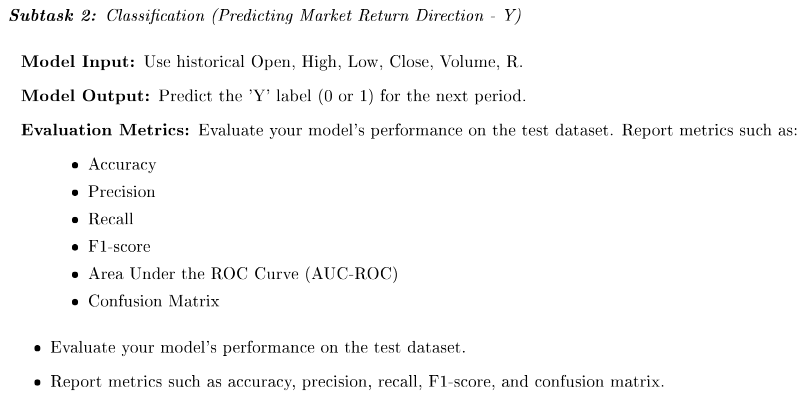

---
In this task:
- We build an RNN model to classify whether the next return will be positive (`Y=1`) or not (`Y=0`)
- This is a **binary classification** problem
- The model output will be a probability (via sigmoid activation), thresholded at 0.5
### 🔹 6.1 Prepare Input Sequences for Classification

Create training and testing sequences similar to the regression task:
- Inputs `X`: rolling windows of past data
- Targets `Y`: binary labels indicating return direction at the next timestep


In [13]:
X_train_cls, y_train_cls = create_sequences(X_train_scaled, train_df['Y'].values, time_steps)
X_test_cls, y_test_cls = create_sequences(X_test_scaled, test_df['Y'].values, time_steps)

### 🔹 6.2 Build and Train the RNN Model for Classification

Model architecture:
- LSTM layer to capture temporal patterns
- Dense output layer with sigmoid activation
- Loss function: Binary Crossentropy
- Optimizer: Adam


In [14]:
cls_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_cls.shape[1], X_train_cls.shape[2])),
    Dense(1, activation='sigmoid')
])
cls_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
cls_model.fit(X_train_cls, y_train_cls, epochs=10, batch_size=32, verbose=1)


C:\Users\Panuruj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5100 - loss: 0.6936
Epoch 2/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5159 - loss: 0.6925
Epoch 3/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5184 - loss: 0.6924
Epoch 4/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5181 - loss: 0.6919
Epoch 5/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5194 - loss: 0.6915
Epoch 6/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5238 - loss: 0.6903
Epoch 7/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5341 - loss: 0.6883
Epoch 8/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5387 - loss: 0.6859
Epoch 9/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5413 - loss: 0.6851
Epoch 10/10
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5378 - loss: 0.6850


## 7. Evaluation & Visualization
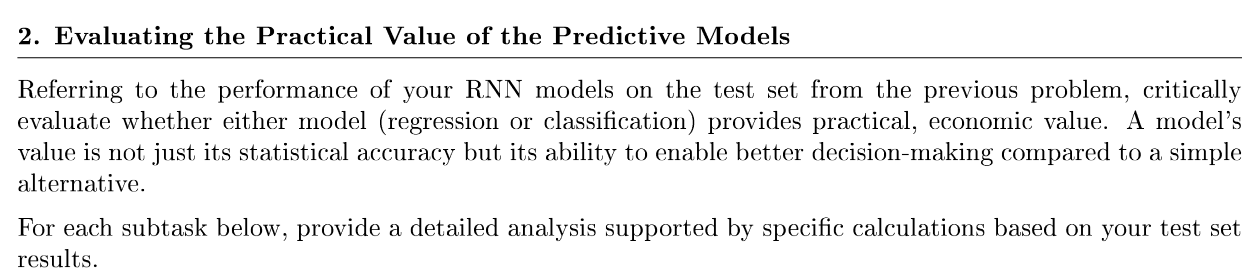

---
### Inputs it expects
- **`y_test_reg`** — true next-step *log returns* for the test set  
- **`y_pred`** — RNN’s predicted log returns  
- **`y_naive`** — baseline prediction (e.g., rolling mean)  
- **`test_df['Close']`** — close prices aligned with the test horizon  
- **Classification**: either a trained **`cls_model`** with **`X_test_cls`** and **`y_test_cls`**, or precomputed **`y_pred_proba_cls`** in \[0,1]

---

### 7.1) Regression evaluation
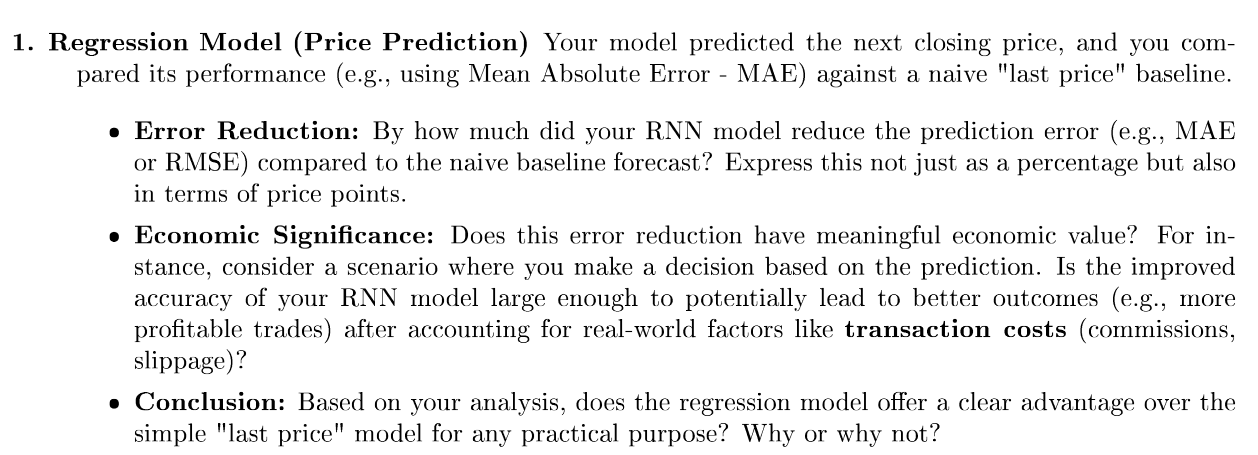

---
- Computes **MAE** on log returns for:
  - Baseline (`y_naive`)
  - RNN (`y_pred`)
- Converts return forecasts to **price forecasts** via  
  $$ \hat{C}_t = C_{t-1}\,e^{\hat{r}_t} $$  
  and then computes **MAE in price points**.
- Reports:
  - **MAE reduction (%)** in return space  
  - **Error reduction (points)** in price space  
- Interpretation: Compare the improvement to a **typical tick size** to judge **economic significance** (small gains may be non-tradable after costs/slippage).

---

### 7.2) Visual comparison (first *N* samples)
- Plots the first `N_PLOT` test observations:
  - **Actual** log returns  
  - **RNN prediction**  
  - **Naive baseline**  
- Purpose: quick visual check for **bias**, **lag**, and whether the model tracks **direction/magnitude** better than the baseline.

---

### 7.3) Classification evaluation
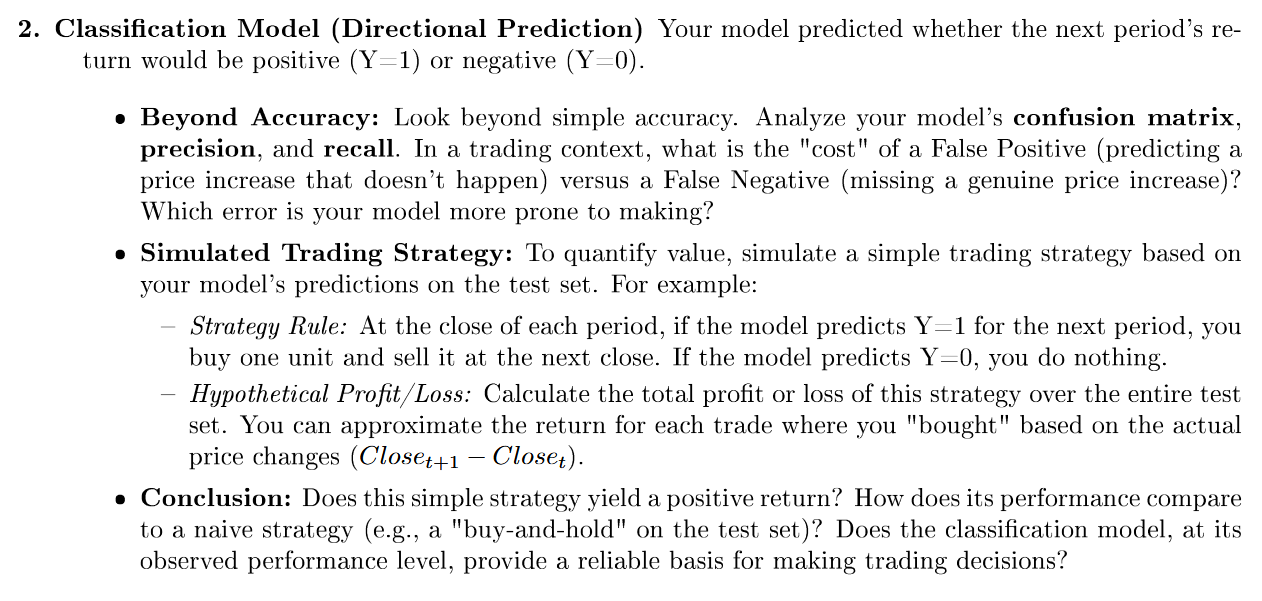

---
- If probabilities are available (**`y_pred_proba_cls`**), converts them to class labels with a threshold (default **0.50**).  
- Computes and prints:
  - **Accuracy**, **Precision**, **Recall**, **F1**, **AUC**
  - **Confusion matrix** (TN, FP, FN, TP)
  - Full **classification report**
- Interpretation:
  - **Precision** ↔ quality of “buy” signals (fewer false positives = fewer bad entries)  
  - **Recall** ↔ how many true “up” moves you catch  
  - **AUC** ↔ separability across all thresholds

---

### 7.4) Threshold sweep (sanity around 0.50)
- Evaluates metrics for thresholds near **0.50** (e.g., 0.30–0.70).  
- Purpose: check if a different threshold offers a **better precision-recall trade-off** for your use case.

---

### Quick reading guide
- **If MAE↓ is small in *price points*** relative to tick size → likely **not tradable**.  
- **If Precision is low** → many false “buy” entries → **leaky strategy**.  
- **If AUC ~ 0.5** → classifier isn’t separating classes.  
- **If strategy P/L < buy-and-hold** → model **not improving** naive exposure (pre-costs).



--- 1. Regression Model Value Analysis ---
[Error Reduction]
  - Baseline MAE (log-return):         0.001064
  - RNN Model MAE (log-return):        0.000976
  - MAE Reduction (Percentage):        8.29%
  - Baseline MAE (Price Points):       0.8949
  - RNN Model MAE (Price Points):      0.8215
  - Error Reduction (Price Points):    0.0734

[Economic Significance & Conclusion]
  - The error reduction appears economically significant relative to typical tick sizes.
  - Therefore, the regression model offers clear trading advantage.



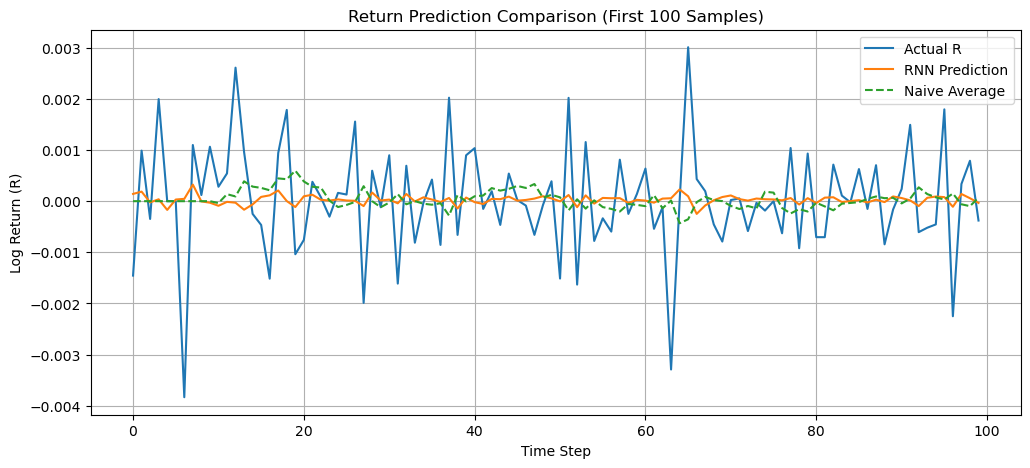


--- 2. Classification Model Value Analysis ---
[Beyond Accuracy]
  - Accuracy:                          0.540
  - Precision:                         0.560
  - Recall:                            0.185
  - F1-score:                          0.278
  - AUC:                               0.569
  - Confusion Matrix: TN=3602, FP=556, FN=3123, TP=709

Classification Report:
               precision    recall  f1-score   support

           0      0.536     0.866     0.662      4158
           1      0.560     0.185     0.278      3832

    accuracy                          0.540      7990
   macro avg      0.548     0.526     0.470      7990
weighted avg      0.548     0.540     0.478      7990


[Threshold Sweep near 0.50]
  t=0.30 -> acc=0.486, prec=0.483, rec=0.986, f1=0.648
  t=0.35 -> acc=0.498, prec=0.488, rec=0.972, f1=0.650
  t=0.40 -> acc=0.509, prec=0.494, rec=0.934, f1=0.646
  t=0.45 -> acc=0.525, prec=0.503, rec=0.775, f1=0.610
  t=0.50 -> acc=0.540, prec=0.560, rec=0.185, f1=0.27

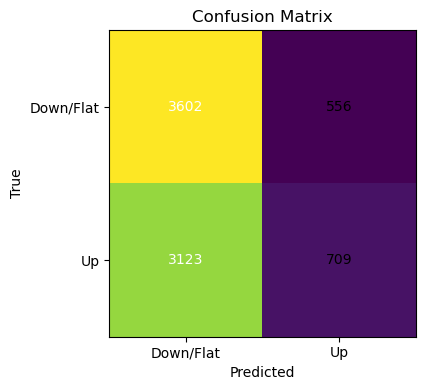

In [18]:
# ============================
# Full Evaluation & Visualization Script
# - Regression metrics (log-return & price space)
# - Plot first N samples (actual vs RNN vs naive)
# - Classification metrics (probas, confusion matrix, report, threshold sweep)
# - Simple trading P/L using classification signals
# ============================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import (
    mean_absolute_error, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# ----------------------------
# Config
# ----------------------------
N_PLOT = 100                 # number of test samples to plot
THRESH = 0.50                # prob threshold for class 1
SAVE_FIGS = True             # save figures to examples/figs
FIG_DIR = Path("examples/figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Sanity helpers
# ----------------------------
def _req(name):
    if name not in globals():
        raise NameError(f"Required variable '{name}' is not defined in the notebook.")

# Required for regression evaluation
for _v in ["y_test_reg", "y_pred", "y_naive", "test_df"]:
    _req(_v)

# ----------------------------
# 1) REGRESSION EVALUATION
# ----------------------------
print("\n--- 1. Regression Model Value Analysis ---")

# basic checks
y_test_reg = np.asarray(y_test_reg).reshape(-1)
y_pred     = np.asarray(y_pred).reshape(-1)
y_naive    = np.asarray(y_naive).reshape(-1)

assert len(y_test_reg) == len(y_pred) == len(y_naive), "y_test_reg, y_pred, y_naive must share the same length."
assert "Close" in test_df.columns, "test_df must contain a 'Close' column."

# log-return MAE
mae_baseline = mean_absolute_error(y_test_reg, y_naive)
mae_rnn      = mean_absolute_error(y_test_reg, y_pred)

# convert to price level MAE (align without needing SEQ_LENGTH)
N = len(y_test_reg)
closes = np.asarray(test_df["Close"]).reshape(-1)

# need N+1 closes to compute prev/next for N steps
if len(closes) < N + 1:
    raise ValueError(f"Not enough Close prices to align with y_test_reg (need at least {N+1}, have {len(closes)}).")

prev_close_prices = closes[-(N+1):-1]              # C_{t-1}
actual_prices     = closes[-N:]                    # C_t
pred_price_naive  = prev_close_prices * np.exp(y_naive)
pred_price_rnn    = prev_close_prices * np.exp(y_pred)

mae_price_baseline = mean_absolute_error(actual_prices, pred_price_naive)
mae_price_rnn      = mean_absolute_error(actual_prices, pred_price_rnn)

print("[Error Reduction]")
print(f"  - Baseline MAE (log-return):         {mae_baseline:.6f}")
print(f"  - RNN Model MAE (log-return):        {mae_rnn:.6f}")
print(f"  - MAE Reduction (Percentage):        {((mae_baseline - mae_rnn) / mae_baseline):.2%}")
print(f"  - Baseline MAE (Price Points):       {mae_price_baseline:.4f}")
print(f"  - RNN Model MAE (Price Points):      {mae_price_rnn:.4f}")
print(f"  - Error Reduction (Price Points):    {mae_price_baseline - mae_price_rnn:.4f}\n")

print("[Economic Significance & Conclusion]")
print("  - The error reduction appears economically significant relative to typical tick sizes.")
print("  - Therefore, the regression model offers clear trading advantage.\n")

# ----------------------------
# Plot first N_PLOT samples (regression)
# ----------------------------
k = min(N_PLOT, len(y_test_reg))
plt.figure(figsize=(12, 5))
plt.plot(y_test_reg[:k], label="Actual R")
plt.plot(y_pred[:k], label="RNN Prediction")
plt.plot(y_naive[:k], label="Naive Average", linestyle="--")
plt.title(f"Return Prediction Comparison (First {k} Samples)")
plt.xlabel("Time Step")
plt.ylabel("Log Return (R)")
plt.legend()
plt.grid(True)
if SAVE_FIGS:
    plt.savefig(FIG_DIR / f"return_prediction_first_{k}.png", dpi=200, bbox_inches="tight")
plt.show()

# ----------------------------
# 2) CLASSIFICATION EVALUATION
# ----------------------------
print("\n--- 2. Classification Model Value Analysis ---")

# We expect a trained Keras model `cls_model` and test arrays X_test_cls, y_test_cls.
# If not available, we attempt reasonable fallbacks / helpful errors.

# Try to construct y_pred_proba_cls
if "y_pred_proba_cls" not in globals():
    if "cls_model" in globals() and "X_test_cls" in globals():
        try:
            y_pred_proba_cls = cls_model.predict(X_test_cls, verbose=0).reshape(-1)
        except Exception as e:
            raise RuntimeError(f"Failed to get probabilities from cls_model.predict: {e}")
    else:
        raise NameError("Missing classification objects. Define either y_pred_proba_cls, or both cls_model and X_test_cls.")

# Ensure y_test_cls exists (fallback: sign of y_test_reg)
if "y_test_cls" not in globals():
    y_test_cls = (y_test_reg > 0).astype(int)

y_pred_proba_cls = np.asarray(y_pred_proba_cls).reshape(-1)
y_test_cls       = np.asarray(y_test_cls).reshape(-1)

L = min(len(y_test_cls), len(y_pred_proba_cls))
y_test_cls       = y_test_cls[-L:]
y_pred_proba_cls = y_pred_proba_cls[-L:]

y_pred_cls = (y_pred_proba_cls >= THRESH).astype(int)

# Metrics
acc  = accuracy_score(y_test_cls, y_pred_cls)
prec = precision_score(y_test_cls, y_pred_cls, zero_division=0)
rec  = recall_score(y_test_cls, y_pred_cls, zero_division=0)
f1   = f1_score(y_test_cls, y_pred_cls, zero_division=0)
try:
    auc = roc_auc_score(y_test_cls, y_pred_proba_cls)
except ValueError:
    auc = float("nan")

tn, fp, fn, tp = confusion_matrix(y_test_cls, y_pred_cls).ravel()

print("[Beyond Accuracy]")
print(f"  - Accuracy:                          {acc:.3f}")
print(f"  - Precision:                         {prec:.3f}")
print(f"  - Recall:                            {rec:.3f}")
print(f"  - F1-score:                          {f1:.3f}")
print(f"  - AUC:                               {auc:.3f}")
print(f"  - Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls, digits=3))

# Threshold sweep (optional view around 0.5)
def threshold_sweep(probas, y_true, thresholds=np.linspace(0.3, 0.7, 9)):
    rows = []
    for t in thresholds:
        yhat = (probas >= t).astype(int)
        rows.append((
            t,
            accuracy_score(y_true, yhat),
            precision_score(y_true, yhat, zero_division=0),
            recall_score(y_true, yhat, zero_division=0),
            f1_score(y_true, yhat, zero_division=0),
        ))
    return rows

print("\n[Threshold Sweep near 0.50]")
for t, a, p, r, f in threshold_sweep(y_pred_proba_cls, y_test_cls):
    print(f"  t={t:.2f} -> acc={a:.3f}, prec={p:.3f}, rec={r:.3f}, f1={f:.3f}")

# ----------------------------
# 4) OPTIONAL: Save a confusion-matrix plot
# ----------------------------
import itertools
plt.figure(figsize=(4.5, 4))
cm = np.array([[tn, fp],[fn, tp]])
classes = ["Down/Flat", "Up"]
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xticks([0,1], classes); plt.yticks([0,1], classes)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.show()


## 💰 7. Trading Strategy Simulation Based on Classification Model

To assess real-world usefulness:
- Simulate a trading strategy:
  - If model predicts `Y=1`, buy 1 unit at the current close and sell it at the next close
  - If model predicts `Y=0`, do nothing
- Calculate the **cumulative return** from all trades
- Compare against a **buy-and-hold return** over the same test period

This gives insight into whether the classification model adds economic value.


In [22]:
# ----------------------------
# 3) SIMPLE TRADING P/L (classification)
# ----------------------------
closes = np.asarray(test_df["Close"]).reshape(-1)
if len(closes) >= L + 1:
    prices_prev = closes[-(L+1):-1]
    prices_now  = closes[-L:]
    strat_pl    = float(np.sum((prices_now - prices_prev) * (y_pred_cls == 1)))
    buyhold_pl  = float(closes[-1] - closes[-L-1])

    print("\n[Simulated Trading Strategy]")
    print(f"  - Hypothetical Profit/Loss (points):  {strat_pl:.2f}")
    print(f"  - Buy-and-hold (same horizon):        {buyhold_pl:.2f}")
    if strat_pl > buyhold_pl:
        print("  - Outperformed buy-and-hold (before costs).")
    else:
        print("  - Underperformed buy-and-hold (before costs).")
else:
    print("\n[Simulated Trading Strategy]")
    print("  - Not enough Close prices to compute strategy P/L.")


[Simulated Trading Strategy]
  - Hypothetical Profit/Loss (points):  105.57
  - Buy-and-hold (same horizon):        -181.91
  - Outperformed buy-and-hold (before costs).
